This vignette describes a MATLAB code that permits to compute the leave-out clustered SEs introduced by <a href="https://eml.berkeley.edu/~pkline/papers/KSS2020.pdf" target="_blank"> Kline, Saggio and Sølvsten (2020)</a> -- KSS henceforth -- in a linear regression model. 


# Introduction


Consider a regression equation of the form

\begin{equation}
y_{ij} =x_{ij}^{\prime } \beta +\varepsilon_{ij} \qquad j=1,...,J; \qquad i=1,...n_{j}; 
\end{equation}

where \(i\) indexes a particular observation which belongs to a cluster $j$ and we have $N= \sum_{j}M_{j}$ total observations; \(x_{ij}\) is a vector of regressors of dimension $K\times1$ and $y_{ij}$ is the outcome of interest. The error terms, $\varepsilon_{ij}$, are assumed to be heteroskedastic and potentially correlated across observations belonging to the same cluster $j$ with a block-diagonal variance-covariance matrix given by

\begin{equation}
\Omega=\left[\begin{array}{cccc}
\mathbf{\Omega}_{1} & 0 & 0 & 0\\
0 & \mathbf{\Omega}_{2} & 0 & 0\\
0 & 0 & \ddots & 0\\
0 & 0 & 0 & \mathbf{\Omega}_{J}
\end{array}\right]
\end{equation}


Cluster robust standard errors for the OLS estimator of $\beta$, $\hat{\beta}$, in most software packages (e.g  \texttt{reghdfe}) is based on the following well-known formula

\begin{equation}
{\mathbb{{\tilde{V}}}}[\hat{\beta}]=d\left(\sum_{i,j}^{N}x_{ij}x_{ij}'\right)^{-1}\left[\sum_{j=1}^J\left(\sum_{i}^{n_{j}}x_{ij}\hat{e}_{ij}\right)\left(\sum_{i}^{n_{j}}x_{ij}\hat{e}_{ij}\right)'\right]\left(\sum_{i,j}^{N}x_{ij}x_{ij}'\right)^{-1},
\end{equation}
where $d$ is some degrees of freedom adjustment and $\hat e_{ij}=y_{ij}-x_{ij}\hat{\beta}$ is the OLS residual.\footnote{For instance, \texttt{reghdfe} sets $d=\dfrac{J}{J-1}\dfrac{N}{N-K}$.}

KSS introduces an unbiased estimate of the variance of $\mathbf{\Omega}_{j}$ given by 
\begin{equation}
    \hat{\mathbf{\Omega}}_{j}=\mathbf{y}_{j}(\mathbf{y}_{j}-\mathbf{x}_{j}\hat{\beta}_{-j})',
\end{equation}
where $\hat{\beta}_{-j}$ is the OLS estimate of $\beta$ obtained after fitting (1) leaving cluster $j$ out; $\mathbf{y}_{j}$ is a $n_{j}\times1$ vector that stacks the outcome variable $y_{ij}$ for observations belonging in cluster $j$; similarly, $\mathbf{x}_{j}$ is a $n_{j}\times K$ matrix that stacks the regressors $x_{ij}$ for the observations belonging to cluster $j$. 

Let $\hat{\eta}_{ij}$, represent the leave-cluster out residual, i.e. $\hat{\eta}_{ij} \equiv y_{ij}-x_{ij}\hat{\beta}_{-j}$. An unbiased estimate of the sampling variability of $\hat{\beta}$ is therefore
\begin{equation}
{\mathbb{{\hat{V}}}}[\hat{\beta}]=\left(\sum_{i,j}^{N}x_{ij}x_{ij}'\right)^{-1}\left[\sum_{j=1}^J\left(\sum_{i}^{n_{j}}x_{ij}y_{ij}\right)\left(\sum_{i}^{n_{j}}x_{ij}\hat{\eta}_{ij}\right)'\right]\left(\sum_{i,j}^{N}x_{ij}x_{ij}'\right)^{-1},
\end{equation}
  
The software described in this vignette, `KSS_SE`, permits to compute ${\mathbb{{\hat{V}}}}[\hat{\beta}]$. We illustrate how the software works in an example where one is interested in fitting an event-study using a two-way fixed effects regression. 

# Computing KSS Standard Errors

The function `KSS_SE` is a `MATLAB` function that takes as input the following:
* `y` outcome variable. Dimension is $N\times 1$.
* `D` treatment(s) of interest. Dimension is $N\times N_{D}$.
* `clusterID` variable that indexes clusters. Dimension is $N\times 1$.
* `indexID` variable that indexes observations within clusters. Dimension is $N\times 1$.
* `controls` additional controls. Dimension is $N\times N_{P}$.

The function computes the KSS leave-out standard errors on the regression coefficients associated with `D`. These SEs are clustered at the level indexed by `clusterID`, after controlling for `controls`, `clusterID` fixed effects as well as `indexID` fixed effects. 

We now demonstrate the functioning of  `KSS_SE` in the context where one is interested in fitting an event study model of the form
\begin{equation}
\label{ES}
y_{it} = \alpha_{i} + \lambda_{t} + \sum_{k=a}^{b}D_{it}^{k}\theta_{k}+X_{it}'\gamma + r_{it}
\end{equation}
where $\alpha_{i}$ are, say, state fixed effects; $\lambda_{t}$ are year fixed effects; $R_{it}$ are event study indicators of the form $D_{it}^{k}\equiv \mathbf{1}\{t=t_{i}^{*}+k\}$ where $t_{i}^{*}$ is the year in which the policy of interest is implemented in state $i$ and $X_{it}$ are some time-varying controls. 

# Building and Exporting the Data To Matlab

We first load up ACS public available data on health insurance using `Stata`. 

In [2]:
import stata_setup
stata_setup.config("/Applications/STATA", "se")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      18.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user network, expiring 19 Aug 2024
Serial number: 401809301518
  Licensed to: Raffaele Saggio
               UBC

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [20]:
%%stata
cd "/Users/raffaelesaggio/Dropbox/LeaveOutTwoWay"
local mixtape https://raw.githubusercontent.com/Mixtape-Sessions
use `mixtape'/Advanced-DID/main/Exercises/Data/ehec_data.dta, clear
l in 1/5
tab year
tab yexp2
gen treated = 1 
replace treated = 0 if yexp2==.


. cd "/Users/raffaelesaggio/Dropbox/LeaveOutTwoWay"
/Users/raffaelesaggio/Dropbox/LeaveOutTwoWay

. local mixtape https://raw.githubusercontent.com/Mixtape-Sessions

. use `mixtape'/Advanced-DID/main/Exercises/Data/ehec_data.dta, clear

. l in 1/5

     +--------------------------------------------+
     |  stfips   year       dins   yexp2        W |
     |--------------------------------------------|
  1. | alabama   2008   .6814122       .   613156 |
  2. | alabama   2009   .6580621       .   613156 |
  3. | alabama   2010   .6313651       .   613156 |
  4. | alabama   2011   .6563886       .   613156 |
  5. | alabama   2012   .6708115       .   613156 |
     +--------------------------------------------+

. tab year

 Census/ACS |
survey year |      Freq.     Percent        Cum.
------------+-----------------------------------
       2008 |         46        8.33        8.33
       2009 |         46        8.33       16.67
       2010 |         46        8.33       25.00
       201

This is a (balanced) state-year panel where the variable `dins` is the outcome of interest and `yexp2` measures the year in which Medicaid was expanded in a given state (it is missing for states that did not expand, like Alabama). Note that the panel runs from 2008 and 2019  and most states expanded in 2014.

We now export to matlab `dins` `stfips` `year` and the set of event study indicators in a .csv called `data_MEDICAID.csv`. To do that, we set $a = -6$ and $b=4$ in (1), export the resulting data and save the results from the resulting event-study specification which we are going to use later

In [21]:
%%stata
rename yexp2 event_year
gen time_rel_event 		= year-event_year
sum time_rel_event
global lb = -6 // winsorize pre-event coefficients at -6
global ub = 4  // winsorize post-event coefficients at 4
replace time_rel_event	=$ub if time_rel_event>=$ub   & time_rel_event!=.
replace time_rel_event	=$lb if time_rel_event<=$lb   & time_rel_event!=.
qui forval k=$lb/$ub {
		local auxname=`k'-$lb
		gen 	D`auxname'	  = 0
		replace D`auxname'	  = 1 if time_rel_event==`k' & treated == 1
}
local norma = -$lb - 1
replace D`norma'=0 // normalize relative to year before implemention
preserve
keep dins D* stfips year
order dins D* stfips year 
drop D`norma' // do not import one event study indicator otherwise MATLAB code would crash because of collinearity issue. 
export delimited using "data/data_MEDICAID.csv", replace novarnames nolabel
restore
reghdfe dins D*, absorb(stfips year) cluster(stfips) noconstant
global fileRESULTS = "data/results_MEDICAID"
qui do "codes/event_plot" // save coefficients and white SE


. rename yexp2 event_year

. gen time_rel_event              = year-event_year
(192 missing values generated)

. sum time_rel_event

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
time_rel_e~t |        360   -1.166667    3.720754        -11          5

. global lb = -6 // winsorize pre-event coefficients at -6

. global ub = 4  // winsorize post-event coefficients at 4

. replace time_rel_event  =$ub if time_rel_event>=$ub   & time_rel_event!=.
(22 real changes made)

. replace time_rel_event  =$lb if time_rel_event<=$lb   & time_rel_event!=.
(20 real changes made)

. qui forval k=$lb/$ub {

. local norma = -$lb - 1

. replace D`norma'=0 // normalize relative to year before implemention
(30 real changes made)

. preserve

. keep dins D* stfips year

. order dins D* stfips year 

. drop D`norma' // do not import one event study indicator otherwise MATLAB cod
> e would crash because of colli

## Running KSS_SE in MATLAB
We now switch to MATLAB and begin by setting the path and the parfor environment.

In [1]:
%% setting path and parfor env
clc
clear
cd '/Users/raffaelesaggio/Dropbox/LeaveOutTwoWay' %% update this to path where you saved the Github package
path(path,'codes'); %this contains the main LeaveOut Routines.

%% parallel envinr (you can uncommment all of this)
%delete(gcp("nocreate")) %clear parallel envir.
%c = parcluster('local'); %tell me # of available cores
%nw = c.NumWorkers; %tell me # of available cores
%pool=parpool(nw,'IdleTimeout', Inf); %all cores will be assigned to Matlab

We now import the data exported by STATA

In [2]:
namesrc='data/data_MEDICAID.csv'; %see build_example_data
data=importdata(namesrc); %import data
y=data(:,1); %outcome variable
D=data(:,2:11); %treatment of interest. in the example D corresponds to 9 event_study dummies. note that event dummy for the year before medicaid was implemented is not imported to avoid multicollinearity issues. 
clusterID=data(:,12); %this is a variable that contains the identifier of the cluster. this is the level at which we are going to cluster the standard errors
year=data(:,13); %other dimension of the panel, in this case this is year (data is state by year panel).
controls=[]; %in this example no controls but the code allows the inclusion of controls
clear data

%%next step is just to assign a label to each column of D, this is not
%%necessary.
for k = -6:-2
    labels{k + 7}               = ['Event-Study Coefficient at ' num2str(k)]; % Adjust the index
end

for k = 0:4
    labels{k + 6}               = ['Event-Study Coefficient at ' num2str(k)]; % Adjust the index
end

We are ready to launch `KSS_SE` by simply calling

In [3]:
%% Run KSS!
[coeff, SE]   = KSS_SE(y,D,clusterID,year,controls,labels); %% this is equivalent in STATA to run reghdfe y D* controls, abs(clusterID year) cluster(clusterID)

%coeff are the event-study coefficients in this application.
%SE are the KSS standard errors for coeff computed by leaving-out cluster c out, as described in Remark 3 of KSS.

out                             = [coeff,SE]; 
s                               = ['data/results_MEDICAID_MATLAB.csv'];
dlmwrite(s, out, 'delimiter', '\t', 'precision', 16); %% saving results in a  .csv

Coefficient on Event-Study Coefficient at -6:  -0.0034914
KSS Standard Error: 0.0089091
******************************************
Coefficient on Event-Study Coefficient at -5:  -0.010823
KSS Standard Error: 0.0068348
******************************************
Coefficient on Event-Study Coefficient at -4:  -0.008634
KSS Standard Error: 0.0075653
******************************************
Coefficient on Event-Study Coefficient at -3:  -0.0049002
KSS Standard Error: 0.0049889
******************************************
Coefficient on Event-Study Coefficient at -2:  -0.0065987
KSS Standard Error: 0.0036725
******************************************
Coefficient on Event-Study Coefficient at 0:  0.044579
KSS Standard Error: 0.0061763
******************************************
Coefficient on Event-Study Coefficient at 1:  0.064338
KSS Standard Error: 0.0065041
******************************************
Coefficient on Event-Study Coefficient at 2:  0.077954
KSS Standard Error: 0.008109
*******

# Interpreting the Output

The code `KSS_SE` prints the event-study coefficients (normalized relative to the year expansion of Medicaid) along with KSS standard errors, clustered at the state level. Below we print an event-study graph (using STATA) that overlays the KSS SEs along with typical cluster-robust standard errors based on White (1980)

In [1]:
import stata_setup
stata_setup.config("/Applications/STATA", "se")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      18.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user network, expiring 19 Aug 2024
Serial number: 401809301518
  Licensed to: Raffaele Saggio
               UBC

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.



. cd "/Users/raffaelesaggio/Dropbox/LeaveOutTwoWay"
/Users/raffaelesaggio/Dropbox/LeaveOutTwoWay

. import delimited "data/results_MEDICAID_MATLAB.csv",clear
(encoding automatically selected: UTF-8)
(2 vars, 10 obs)

. 
. gen rows                = _n

. rename v1 coeff_KSS

. rename v2 SE_KSS

. gen lower_KSS = coeff_KSS-1.96*SE_KSS

. gen upper_KSS = coeff_KSS+1.96*SE_KSS

. merge 1:1 rows using "data/results_MEDICAID", nogen

    Result                      Number of obs
    -----------------------------------------
    Not matched                             0
    Matched                                10  
    -----------------------------------------

. sort x

. twoway (scatter coeff_ut x, mcolor(dknavy) lcolor(dknavy) msymbol(square) con
> nect(direct) legend(label(1 "CI based on Cluster-Robust White SE"))) ///
>            (rcap lower_ut upper_ut x, lcolor(dknavy) legend(label(2 ""))) ///
>  
>            (scatter coeff_KSS x, mcolor(cranberry) lcolor(cranberry) msymbol(
> squ

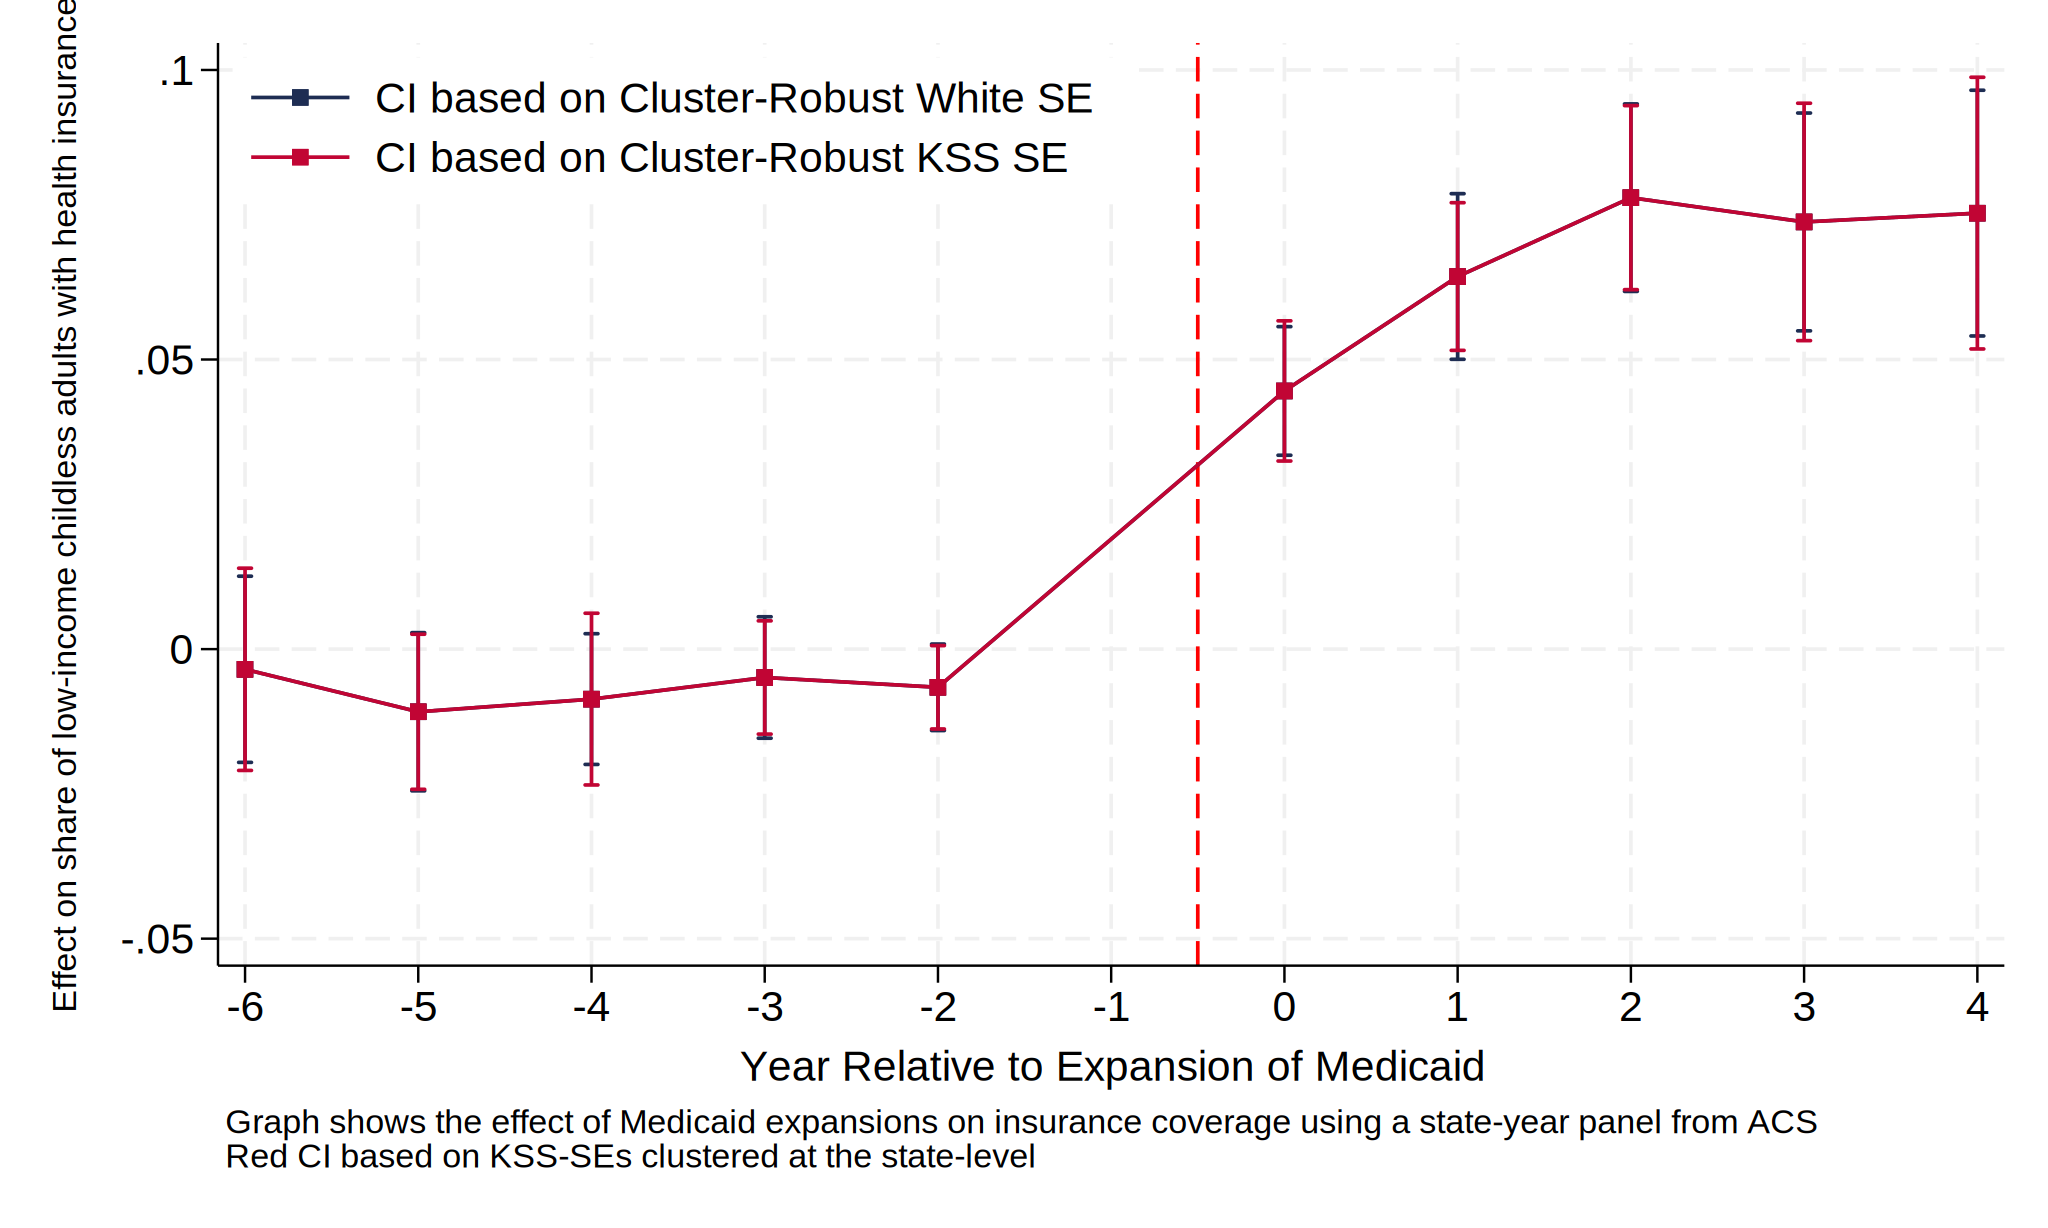

In [5]:
%%stata
cd "/Users/raffaelesaggio/Dropbox/LeaveOutTwoWay"
import delimited "data/results_MEDICAID_MATLAB.csv",clear

gen rows 		= _n
rename v1 coeff_KSS
rename v2 SE_KSS
gen lower_KSS = coeff_KSS-1.96*SE_KSS
gen upper_KSS = coeff_KSS+1.96*SE_KSS
merge 1:1 rows using "data/results_MEDICAID", nogen
sort x
twoway (scatter coeff_ut x, mcolor(dknavy) lcolor(dknavy) msymbol(square) connect(direct) legend(label(1 "CI based on Cluster-Robust White SE"))) ///
	   (rcap lower_ut upper_ut x, lcolor(dknavy) legend(label(2 ""))) /// 
	   (scatter coeff_KSS x, mcolor(cranberry) lcolor(cranberry) msymbol(square) connect(direct) legend(label(3 "CI based on Cluster-Robust KSS SE"))) ///
	   (rcap lower_KSS upper_KSS x, lcolor(cranberry) legend(label(4 ""))), /// 
		xlabel(-6(1)4) ytitle("Effect on share of low-income childless adults with health insurance", size(small)) xtitle("Year Relative to Expansion of Medicaid") legend(order(1 3)) legend(ring(0) position(11) rows(2)) xline(-0.5, lcolor(red) lpattern(dash))  graphregion(color(white)) bgcolor(white) note("Graph shows the effect of Medicaid expansions on insurance coverage using a state-year panel from ACS" "Red CI based on KSS-SEs clustered at the state-level")

keep coeff_KSS SE_KSS se_ut x
rename coeff_KSS coeff
rename se_ut SE_WHITE
list
save "data/final_TABLE_comparison_KSS",replace



As shown in KSS, the standard errors printed by `KSS_SE`, are unbiased while "White" standard errors reported by standard packages (e.g. `reghdfe`)  are consistent but are typically biased in finite samples, especially when the number of clusters is small. 